# Evolutionary Computing Exercise No. 3
**Stu. Name:** Mohammad Amin Dadgar

**Stu. Id:** 4003624016

This is the third project for evolutionary computing course in Isfahan university instructed by Dr. Hossein Karshenas. In this project we practised another type of evolutionary algorithms named Neural Architecture Search (NAS). NAS algorithm is used here to find the best architecture of a transformer network that has the ability to classify the imdb dataset. There are two positive and negative classes available that the best network architecture will have the highest accuracy and lowest loss.

## Algorithm Configurations

### Representation
Representation for our algorithm has three levels.

- First level is just showing a concept for the network architecture in which the green boxes are optional (can be shown or not, 0 or 1)

    <img src='architecture_level1.png'>
- Second level is representing the transformer layer

    <img src='architecture_level2.png'>
- And the third level is showing the FFN and feed-forward network architectures

    <img src='architecture_level3.png'>

For each gene we can use numerical values which are 0 to 9. As we can see in the exercise each hyperparameter has 2, 3, or 4 values and by that we can convert the numerical values from intervals as below

**Two valued hyperparameters:**
- 0:4 → 0
- 5:9 → 1

**Three valued hyperparameters:**
- 0:3 → 0
- 4:6 → 1
- 7:9 → 2

**Four valued hyperparameters:**
- 0:1 → 0
- 2:4 → 1
- 5:7 → 2
- 8:9 → 3

**100 valued hyperparameters:**
- 0 → 0
- 1 → 10
- 2 → 20
- ...
- 9 → 90
- And 100 would not really work in our 100 valued parametered dropout probability, so we'll exclude it from possible values. 


So to represent a chromsome `1+3×(3+3×2)+3` bits are requierd. The first `1` is $d_{model}$, then in the clause `3×(3+3×2)+3`, the first `3` is showing three possible transform layers. In the paranthesis the first `3` is showing the bit for attention head count and normalization layers then the `3` in multiplication is the count of possible hyperparameters in FFN layer (we could have 2 FFN layer in a transformer) and the last `3` in the equation is the final FFN layer for the network. So `31` bits will be used.

### Recombination and Mutation
To combine chromsomes for two recombination and mutation methods, we should assume the three level architecture for it. To that aim, We had implemented the mutation based on the conceptual (level 1) chromosome meaning the transformers and FFN layer are mutated as a pack. For recombination method, a normal single point or uniform cross-over can be used.

To explain the methods further, it is possible to say that the mutation of a layer will make the values in phenotype chromosomes `None` or cantrarily it will set a value for  `None` values, which the model wouldn't have that kind of layer (or it would have the layer). For recombination the normal cross-over methods is applied.

### End Condition
The end condition is the count of generations, which is 10 as given in the exercise but we evaluated the algorithm in 12 generations to evalute the algorithm results further.
### Fitness Function
The fitness function is assumed the training 5 epoch of the transformer network and returning the 5 average test loss of it. As we will see the transfomer network does have high computational complexity (in time and hardware resources), so that's the reason that the end condition, averaging count, and epochs are set as low as they can be. 

The algorithm has run in google colab which gives a free GPU service for about 4 to 5 hours and to use more another the code and the results was transfered into another google account.  

### libraries used 
in this project [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [keras](https://keras.io/), and [random](https://docs.python.org/3/library/random.html) libraries were used. numpy was used to create and modify array like structures and matplotlib is a visualization library that does the works to visualize our results. keras is a library on top of tensorflow which gives an abstraction level of the neural network and it hides the complexities of creating a neural network for the user. With keras we implemented our neural network and trained it to get the predictions. random is a python modules which gives random number and it was used in our population generation, mutation, and recombination methods. 

In [1]:
## the libraries from other contributers
import numpy as np
import os ## a python default library
import matplotlib.pyplot as plt

## our written codes
from population import generate_population
from combination import mutation_creep, single_point
from util import convert_genotype_to_phenotype_values
from selection import binary_tournament
from transformer_network_creator import fitness_evaluate, create_model


In [2]:
def algorithm_run(pop_count, SELECTION_METHOD, FITNESS_FUNCTION, MUTATION_METHOD, RECOMBINATION_METHOD, start_generation, last_population=None, last_population_fitness = None, p_m=0.1, p_c =0.9 ,max_generations = 10, RESULTS_DIR='/content/gdrive/MyDrive/EC Project/'):
    """
    one constraint should be always given as input, the maximum capacity or maximum distance
    """
    ## if we had generated population before
    if last_population is None:
      population = generate_population(pop_size=pop_count)
      fitness_pop = []
      for chromosome in population:
          chromosome_fitness = FITNESS_FUNCTION(chromosome, None, 5)
          fitness_pop.append(chromosome_fitness)
    else:
      print('Population is loaded from file!\n')
      fitness_pop = last_population_fitness
      population = last_population


    best_chromosome = None
    best_chromsome_fitness = None
    
    generation_num = 0
    if start_generation is not None:
      generation_num = start_generation
    for generation_idx in range( generation_num ,max_generations):
        print('*' * 30 + f'Generation Number: {generation_idx}' + '*' * 30)


        ## create pair of the parents
        parent_pairs = []
        for _ in range(pop_count):
            pair = SELECTION_METHOD(population, fitness_pop)
            parent_pairs.append(pair)

        
        offsprings = []
        fitness_offsprings = []
        for parents in parent_pairs:
            recombination_p = np.random.random()

            ## the offspring for this iteration
            ## first save the parents to change them later
            iteration_offspring = [parents[0], parents[1]]
            
            ######## Recombination ########
            if recombination_p < p_c:
                offspring1, offspring2 =  RECOMBINATION_METHOD(iteration_offspring[0], iteration_offspring[1])

                iteration_offspring = [offspring1, offspring2]

            ######## Mutation ########
            offspring1 = MUTATION_METHOD(iteration_offspring[0], p_m)
            offspring2 = MUTATION_METHOD(iteration_offspring[1], p_m)

            iteration_offspring = [offspring1, offspring2]
                
            ## finally append the genarated offsprings to offspring array 
            offsprings.append(iteration_offspring[0])
            offsprings.append(iteration_offspring[1])
            
            fitness_offsprings.append(FITNESS_FUNCTION(iteration_offspring[0], RESULTS_DIR + f'NEW_generation_number_{generation_idx}.txt', 5))
            fitness_offsprings.append(FITNESS_FUNCTION(iteration_offspring[1], RESULTS_DIR + f'NEW_generation_number_{generation_idx}.txt', 5))
            
                
        ######## Replacement ########

        ## the whole generation: parents + offsprings
        generation_population = population.copy()
        generation_population.extend(offsprings)

        ## whole generation fitness: parents fitness + offsprings fitness
        generation_fitness = fitness_pop.copy()
        generation_fitness.extend(fitness_offsprings)

        ## the sorted generation
        generation_population_sorted = np.array(generation_population)[np.argsort(generation_fitness)]
        generation_fitness_sorted = np.sort(generation_fitness)

        ## Step 10
        ## extract the best of the new generation
        best_of_generation_population = generation_population_sorted[:pop_count]
        best_of_generation_fitness = generation_fitness_sorted[:pop_count]

        best_chromosome = generation_population_sorted[0]
        best_chromsome_fitness = generation_fitness_sorted[0]
        
        ## save them into the original population arrays
        population = best_of_generation_population.tolist()
        fitness_pop = best_of_generation_fitness.tolist()

    return best_chromosome, best_chromsome_fitness

In [ ]:
################ This part ran on colab and won't be run here ################
answer_chromosome, answer_chromsome_fitness = algorithm_run(pop_count=10, 
                SELECTION_METHOD=binary_tournament, 
                FITNESS_FUNCTION=fitness_evaluate, 
                MUTATION_METHOD=mutation_creep, 
                RECOMBINATION_METHOD=single_point,
                p_m=0.1,
                p_c=0.9,
                max_generations=14, 
                last_population=None,
                last_population_fitness=None, 
                start_generation=10)

## Results
The algorithm ran on google colab in different sessions to complete the results. While running on colab we saved the results in a file. The content of each file shows the genotype chromosomes with 5 evaluation of the created model on test set. The results of evaluations are shown using the loss metric, so the less the value represents a better model.    

In [3]:
All_pop = []
All_pop_fitness = []

for i in range(12):
    ## Reading the last saved population
    ## comment this code if you are starting from scratch
    with open(os.path.join('results', f'NEW_generation_number_{i}.txt'), 'r') as file:
        information = file.read()

    population = []
    population_fitness = []
    for individual_info in information.split('\n'):
        if individual_info != '':
            individual, individual_fitness_str_arr = individual_info.replace(' ', '').split(':') 
            ## convert to their specific types
            individual = str(individual)
        
            float_data_arr = individual_fitness_str_arr.replace('[', '').replace(']', '').split(',')
            float_data_arr = [float(data) for data in float_data_arr]
            individual_fitness = np.mean(float_data_arr)

            population.append(individual)
            population_fitness.append(individual_fitness)
    All_pop.append(population)
    All_pop_fitness.append(population_fitness)

In [4]:
All_pop = np.array(All_pop)
All_pop_fitness = np.array(All_pop_fitness)

All_pop.shape

(12, 20)

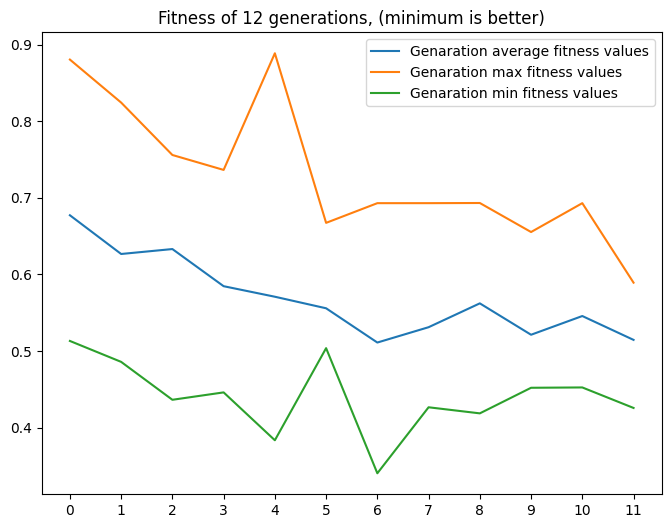

In [5]:
plt.figure(figsize=(8, 6))
plt.title('Fitness of 12 generations, (minimum is better)')
generation_mean = np.mean(All_pop_fitness, axis=1)
generation_max = np.max(All_pop_fitness, axis=1)
generation_min = np.min(All_pop_fitness, axis=1)
plt.plot(generation_mean, label='Genaration average fitness values')
plt.plot(generation_max, label='Genaration max fitness values')
plt.plot(generation_min, label='Genaration min fitness values')
plt.xticks(np.arange(12))
plt.legend()
plt.show()

In [6]:
## The best chromosome representing the network architecture
best_chromosome = All_pop.flatten()[np.argmin(All_pop_fitness)]
best_phenotype = convert_genotype_to_phenotype_values(best_chromosome)

print(f'Best Chromosome is: \n{best_chromosome}\nAnd its phenotype is: \n{best_phenotype}\nFitness Value is: {np.min(All_pop_fitness)}')

Best Chromosome is: 
0738671731000000000000000000596
And its phenotype is: 
(16, ((20, 'R', 0.8, False), (20, 'R', 0.7, True), 1), ((None, None, None, None), (None, None, None, True), 1), ((None, None, None, None), (None, None, None, True), 1), (20, 'S', 0.6))
Fitness Value is: 0.34032297134399414


In [7]:
model = create_model(best_chromosome)
print("best model")
model.summary()

best model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 16)          323200    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 200, 16)          2472      
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 20)           

So as we can see from the plotted results, it seems the best chromosome was created in sixth generation, which is printed above. The fitness landscape is representing that until the sixth generation, the fitness values were being better but the exploration in the problem was so high that the algorithm came out of the optimum value and explored other chromosomes. 

The generation of the population was in a way that no None values were available meaning the network has more layers in start but as the generations goes on, the less the layers came and as a conclusion of this phenomenon, we can say that the complex networks doesn't have the best accuracy and loss values.
 
The best model is also being printed in the cell above and it is simple to use the model in real world problems. 

To see the best chromosome accuracy we evalueted it further here in the cell below.

In [8]:
################ This cell has run on our system ################
fitness_evaluate(best_chromosome, None)

25000 Training sequences
25000 Test sequences
Epoch 1/5
391/391 - 10s - loss: 0.7014 - accuracy: 0.5073 - 10s/epoch - 26ms/step
Epoch 2/5
391/391 - 7s - loss: 0.4444 - accuracy: 0.8138 - 7s/epoch - 18ms/step
Epoch 3/5
391/391 - 6s - loss: 0.2648 - accuracy: 0.9150 - 6s/epoch - 16ms/step
Epoch 4/5
391/391 - 5s - loss: 0.1975 - accuracy: 0.9446 - 5s/epoch - 14ms/step
Epoch 5/5
391/391 - 5s - loss: 0.1446 - accuracy: 0.9596 - 5s/epoch - 13ms/step
782/782 [==============================] - 6s 8ms/step - loss: 0.4625 - accuracy: 0.8602
25000 Training sequences
25000 Test sequences
Epoch 1/5
391/391 - 6s - loss: 0.7250 - accuracy: 0.5100 - 6s/epoch - 16ms/step
Epoch 2/5
391/391 - 5s - loss: 0.3890 - accuracy: 0.8370 - 5s/epoch - 13ms/step
Epoch 3/5
391/391 - 5s - loss: 0.2268 - accuracy: 0.9252 - 5s/epoch - 13ms/step
Epoch 4/5
391/391 - 5s - loss: 0.1697 - accuracy: 0.9504 - 5s/epoch - 14ms/step
Epoch 5/5
391/391 - 6s - loss: 0.1291 - accuracy: 0.9660 - 6s/epoch - 16ms/step
782/782 [========

0.4084173679351807


There are many options available to improve the algorithm for future works that we've listed them below:
- The fitness values are chosen to be the mean test loss values of the network in 5 time training, but to imrove it we could add or divide the fitness values based on the number of layers in network, in which for 2 networks the one that has less layers would be prefered to be chosen.
- To avoid the problem of comming out of the optimum point in lastest generations, we could present an adaptive version of evolutionary algorithm in which for the lastest layers the mutation rate becomes less.
- To increase tha variety of the chromosomes, the diversity preservation algorithms could be used (Not sure about how can they improve the algorithm but can be tested).
- The binary tournament selection method is used here but other methods can be also applied.